## Описание проекта.
Заказчиком исследования является интернет-магазине «Стримчик». Основной деятельностью является продажа компьютерных игр по всему миру. Из открытых источников были предоставлены исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит заказчику сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Подготовка данных для анализа.

### Импорт данных и их предварительная оценка:

Для работы с данными предварительно подключим необходимые библиотеки:

In [1]:
### importing necessary libraries to work with the dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy import stats as st
import seaborn as sns

Читаем датасет и передаём его в переменную с которой позднее и будем работать.

In [2]:
### opening the dataset for work:
data = pd.read_csv('games.csv')

Выведем основные параметры датасета для того, чтобы получить высокоуровневое понимание структуры данных и их состояния:

In [3]:
### checkinig the general dataset view:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Для дальнейшей работы мы приведём названия столбцов к нижнему регистру и посмотрим, какие данные возможно необходимо привести к другому типу, который им более подходит. Также далее проработаем необходимость заполнения пропусков и варианты заполнения.

### Переименование столбцов:

Приведём названия столбцов датасета к нижнему регистру для удобства обработки:

In [4]:
### changing columns names to lowercase
data.columns = data.columns.str.lower()

Выведем данные о названиях столбцов после приведёния к нижнему регистру для проверки, что все прошло успешно:

In [5]:
### showing the lowercased names of the dataset columns 
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка аномальных и нерелевантных значений:

Так как нам прежде всего поставлена задача проанализировать закономерности коммерчески успешных игр, то целесообразно отбросить сразу данные по играм, которые не были коммерчески успешными. Их можно отдельно потом проанализировать, если потребуется уже понять почему они были неуспешны. Для того, чтобы игра считалась коммерчески успешной примем продажи более 10000 копий на всех рынках. 2016 год не учитываем, так как по нему данные не полные. Для того, чтобы ранжировать игры по данному параметру, введём новый столбец в который поместим суммарные продажи по всем рынкам:

In [6]:
### adding the new column in the dataset to summarize sales across all regions
data['sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [7]:
### cheking how many rows we have with overall sales lower than 10k items and not released in 2016
data.query('sales <= 0.01 & year_of_release != 2016')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
15384,Order of War,PC,2009.0,Strategy,0.00,0.01,0.00,0.0,69.0,7.3,T,0.01
15499,Motocross Mania 3,XB,2005.0,Racing,0.01,0.00,0.00,0.0,38.0,3.6,T,0.01
15520,Pump It Up: Exceed,XB,2005.0,Misc,0.01,0.00,0.00,0.0,74.0,7.5,T,0.01
15542,Digimon Rumble Arena 2,XB,2004.0,Fighting,0.01,0.00,0.00,0.0,65.0,8.8,T,0.01
15564,Super Fruit Fall,Wii,2006.0,Puzzle,0.01,0.00,0.00,0.0,NaN,NaN,E,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
16707,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.0,NaN,NaN,NaN,0.01
16708,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN,0.01
16709,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,0.00,0.00,0.00,0.0,NaN,NaN,NaN,0.00
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN,0.01


In [8]:
### looking for the indexes in the dataframe to delete based on condition
to_drop = data.loc[(data['sales'] <= 0.01) & (data['year_of_release'] != 2016)].index

In [9]:
### dropping the irrelevant data
data.drop(to_drop, inplace=True)

### Работа с пропусками в датасете и приведние данных к необходимому типу:

Для начала введем опять же информацию о датасете для верхнеуровневой оценки пропусков:

In [10]:
### showing general information about the dataset to check missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15994 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             15992 non-null  object 
 1   platform         15994 non-null  object 
 2   year_of_release  15744 non-null  float64
 3   genre            15992 non-null  object 
 4   na_sales         15994 non-null  float64
 5   eu_sales         15994 non-null  float64
 6   jp_sales         15994 non-null  float64
 7   other_sales      15994 non-null  float64
 8   critic_score     7923 non-null   float64
 9   user_score       9708 non-null   object 
 10  rating           9646 non-null   object 
 11  sales            15994 non-null  float64
dtypes: float64(7), object(5)
memory usage: 1.6+ MB


#### ***Столбец 'name':***

##### Обработка пропусков.

Как мы видим, в данном столбце всего два пропуска (не говоря о том, что сложно анализировать продажи игры без имени...) и мы их можем просто удалить.

In [11]:
### verifying how many missing data we have in 'name' column
data['name'].isna().sum()

2

In [12]:
### dropping lines where data in 'name' is missing
data = data.dropna(subset=['name'])

##### Приведение данных к необходимому типу.

Данный столбец относится к типу данных object и содержит строковые данные. Его приведение к новому типу не требуется.

#### ***Столбец 'year_of_release':***

##### Обработка пропусков.

Так как год выпуска игры не является определяющим для её успешности и удалить пропуски мы не можем просто потому что тогда мы потеряем данные по продажам определённых игр, то в данном случае будет уместно заполнить их нулями. Количество подобных пропусков не велико и не отразится на качестве анализа. Для начала посмотрим, сколько у нас пропусков:

In [13]:
### checking how many missed data in the 'year_of_release' column
data['year_of_release'].isna().sum()

250

И заполним всё нулями:

In [14]:
### filling missing data with 0´s
data['year_of_release'] = data['year_of_release'].fillna(0)

##### Приведение данных к необходимому типу.

Проверим, какие уникальные значения есть в этом столбце просто потому, что тип хранения в виде числа с плавающей точкой мог быть выбран, чтобы в дробной части указать месяц выпуска.

In [15]:
### checking unique information in the column to verify that there is no fractional part
data['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,    0., 1995., 1991., 1981., 1987.,
       1980., 1983.])

Как мы видим, дробная часть всегда нулевая и более того, указаны только года. Разумным является привести этот столбец к целочисленному типу:

In [16]:
### converting float to int64
data['year_of_release'] = data['year_of_release'].astype('int32')

In [17]:
### verifying new data type
data['year_of_release'].dtype

dtype('int32')

#### ***Столбец 'critic_score':***

##### Обработка пропусков.

Так как оценки это очень субъективное понятие, то заполнить пропуски каким-то усреднённым значением не является правильным решением. Мы не будем обрабатывать пропуски в данном столбце.

##### Приведение данных к необходимому типу.

Данный столбец уже относится к типу данных с плавающей точкой и его приведение к новому типу не требуется. Однако значенния в нём приведены по шкале от 0 до 100 в отличии от пользовательских оценок, которые используют шкалу от 0 до 10. Приведём данные в 'critic_score' к той же шкале:

In [18]:
data['critic_score'] = data['critic_score'] / 10

#### ***Cтолбец 'user_score':***

##### Приведение данных к необходимому типу.

Несмотря на то, что в данном столбце должны быть числовые данные с плавающей точкой, мы видим, что на данный момент его тип отображается как object, то есть строковый.

In [19]:
### verifying the type of the data in the 'user_score' column
data['user_score'].dtype

dtype('O')

Проверим, какие данные содержаться в столбце и почему ему был присвоен такой тип:

In [20]:
### checking unique items in that column to understand why type is Object
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Мы видим, что некоторые строки содержат значение 'tbd', то есть - to be defined. Оно используется, когда оценки нет и она только ожидается. К сожалению, ожидание затянулось и нам как-то надо заполнить и эти поля и пропуски. Для заполнения пропусков нам необходимо перевести данные из строковых в числовые. Для этого мы присваиваем всем строкам у которых есть tbd в столбце 'user_score' пропуск и далее уже сможем сконвертировать данные в подходящий формат и обработать:

In [21]:
### replacing 'tbd' string with nan
data.replace('tbd', np.nan, inplace=True)

Теперь у нас есть возможность конвертировать данные в числовой тип:

In [22]:
### converting object data type to float64
data['user_score'] = data['user_score'].astype('float32')

##### Обработка пропусков.

Так как оценки это очень субъективное понятие, то заполнить пропуски каким-то усреднённым значением не является правильным решением. Мы не будем обрабатывать пропуски в данном столбце.

#### ***Cтолбец 'rating'***

##### Обработка пропусков.

Причины отсутствия данных в столбце 'rating' могут быть как связаны с тем, что рейтинг ESRB игре не присвоен (что маловероятно, так как без данного рейтинга игру не допустят к продажам в Америке (это не закон, но так действует общественный договор),  либо, что данная игра не предназначалась для рынка Северной Америки и продавалась в Европе или Азии. Альтернативно может быть, что игра вышла до 1994 года, когда данный рейтинг начал применяться.
В любом случае продобные пропуски можно заполнить значением RP - rating pending.

In [23]:
### filling 'rating' column missing data with RP abbreviation
data.rating = data.rating.fillna('RP')

In [24]:
### checking that we have no more NaN's
data['rating'].unique()

array(['E', 'RP', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC'], dtype=object)

##### Приведение данных к необходимому типу.

Мы можем привести данный тип данных из строкового object в категорийный category. Не то, чтобы это на что-то влияет, но экономит память и более точно отражает что за данные мы храним.

In [25]:
### converting data in 'rating' column to categorical
data['rating'] = data['rating'].astype('category')

#### ***Столбцы 'genre' и 'platform'***

##### Обработка пропусков.

В данных столбцах обработка пропусков не требуется.

##### Приведение данных к необходимому типу.

Приводим тип данных из строкового object в категорийный category для обоих столбцов. Это экономит память и более точно отражает что за данные мы храним.

In [26]:
### converting data in 'rating' column to categorical
data['genre'] = data['genre'].astype('category')

In [27]:
### converting data in 'platform' column to categorical
data['platform'] = data['platform'].astype('category')

### Вывод:

После предварительного анализа данных мы смогли привести данные в надлежащий вид и подготовить их для исследовательского и статистического анализа. Мы обработали пропуски в столбцах 'rating', 'name' и 'year_of_release', но в столбцах 'user_score' и 'critic_score' пропущенные значения не стали убирать так как это бы могло отразиться на качестве анализа. Все типы данных были преобразованы в необходимые и датасет полностью готов к дальнейшей работе.

## Исследовательский анализ данных.

### Анализ количества игр выпускаемых в разные годы:

Так как мы не стали отбрасывать данные, где у нас были пропуски в столбце 'year_of_release', а преобразовали их в 0, то сейчас нам необходимо что-то временно с этими данными сделать, так как иначе график 'поплывёт' из-за наличия 0 года.
Для этого мы создадим временный датасет без тех игр, которые были выпущенны в 0 году. Количество поддобных игр не большое, так что это не повлияет на анализ:

In [28]:
### selecting what to drop from the main dataset
to_drop = data.loc[data['year_of_release'] == 0].index

In [29]:
### creating a new temporary dataset without irrelevant data
new_data = data.drop(to_drop)

Теперь создадим группировку данных по годам и построим на её основе график выпускаемых игр по годам:

In [30]:
### making the necessary pivot_table
games_per_year = new_data.pivot_table(index='year_of_release', values='name', aggfunc='count')

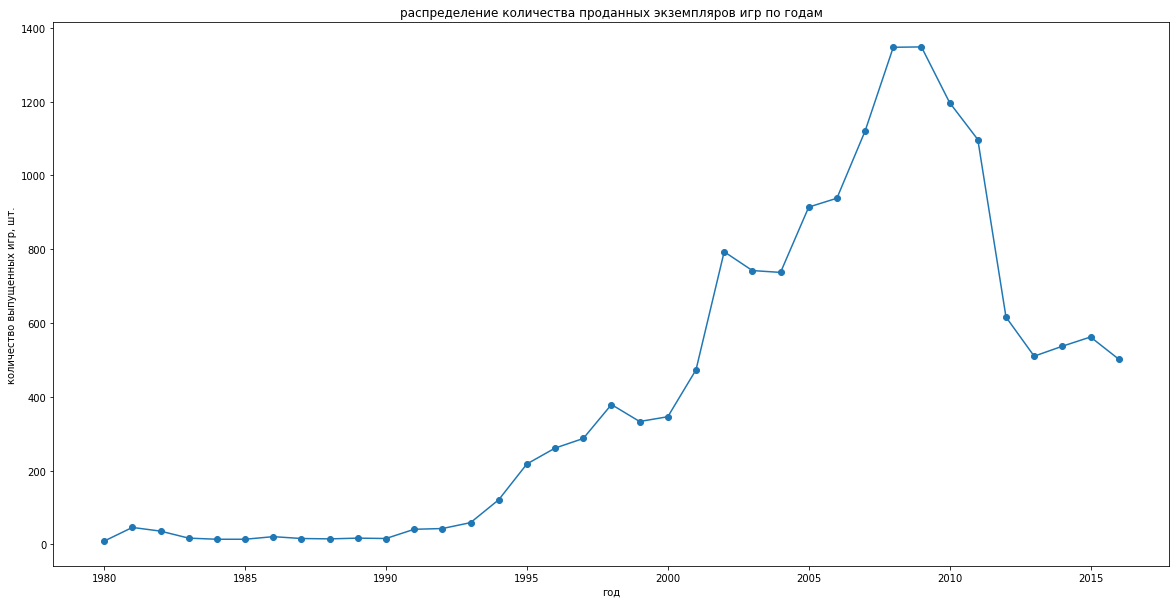

In [31]:
### creating the plot based on the data from the pivot table
games_per_year.plot(figsize=(20,10), style='o-',title='распределение количества проданных экземпляров игр по годам', xlabel='год', ylabel='количество выпущенных игр, шт.', legend=False);

На графике видно, что начиная с 1980 года и почти 15 лет количество игр не сильно менялось от года к году. После 1995 года, в соедующие 15 лет количество выпускаемых игр расло экспонентециально. Однако уже начиная с 2010 года произошел резкий спад. Последние 5 лет количество издаваемых игр оставалось на уровне 2000 года и лишь незначительно подвергалась колебаниям. Ддя более точного анализа и прогнозов рекомендуется рассмотреть период с 2012 по 2015 года так так необходимо более углублённо рассмотреть что влияет на продажи, если количество релизов не сильно меняется.

###  Анализ продаж по платформам:

Для проведения подобного анализа мы сделаем следующее:
- выберем платформы с наибольшими суммарными продажами и построим распределение по годам. 
- постараемся ответить на вопрос за какой характерный срок появляются новые и исчезают старые платформы?

Для ответа на первый вопрос нам необходимо построить сводную таблицу о том, какие платформы в какие годы приносили сколко дохода:

In [32]:
### making a pivot table showing how much money each platform got each year
platforms_year = new_data.pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc=sum)

Далее мы строим графики для каждой платформы, которые позволят нам визуализировать данные:

In [33]:
### creating the pivot table only with items where data is present. If not - fill with NaN
platforms_year_3 = new_data.pivot_table(index='year_of_release', columns='platform', values='sales', \
                                        aggfunc=sum, observed=True)

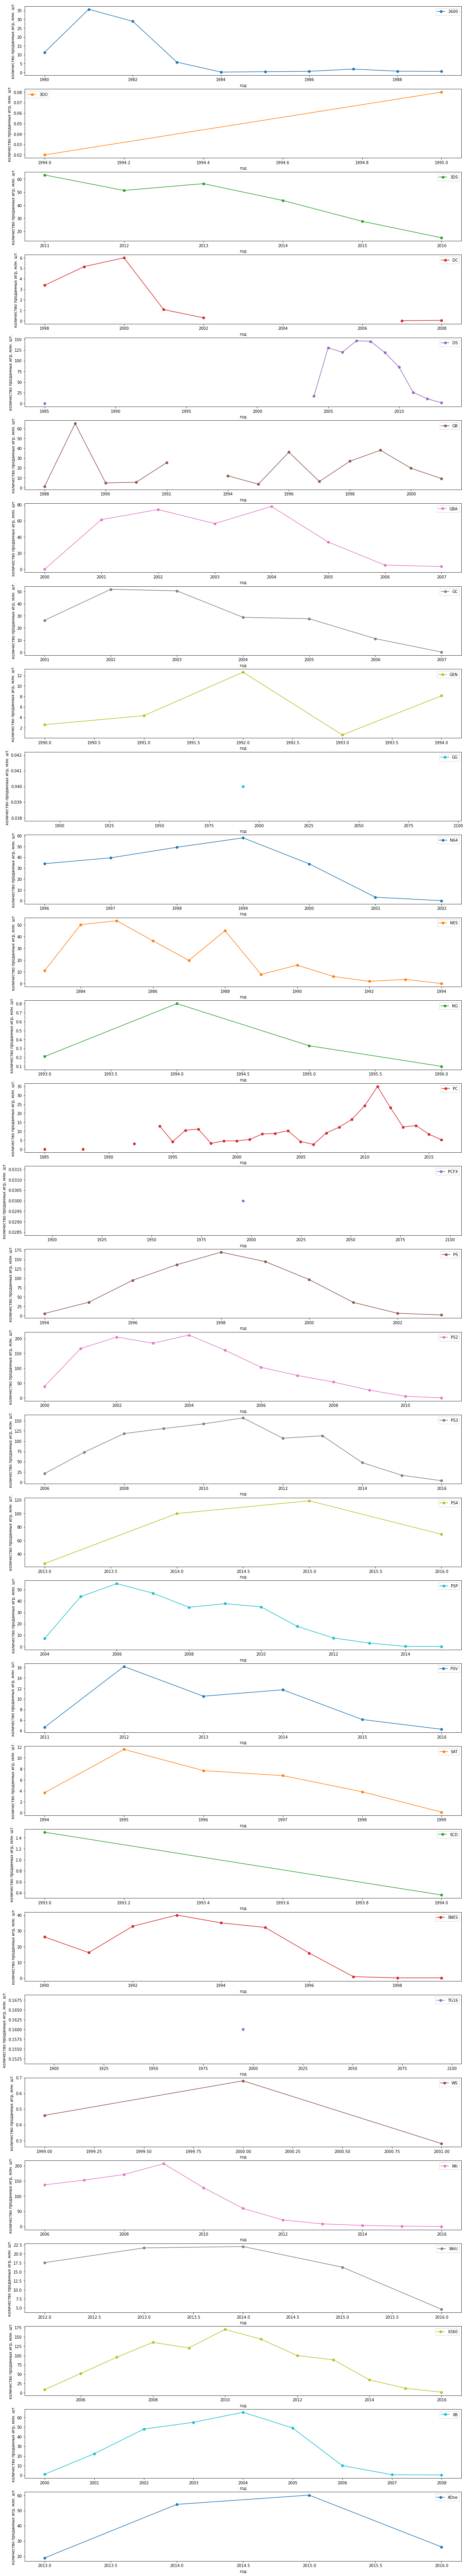

In [34]:
### creating the plot based on picot table
platforms_year_3.plot(figsize=(20,120),xlabel='год', ylabel='количество проданных игр, млн. шт.', \
                      subplots=1, sharex=False, style='o-');

Если проанализировать графики, то можно сделать вывод, что в среднем игровая платформа актуальна в течении 5-лет с момента своего выпуска и в текущем периоде необходимо сосредоточится на PS4 и его преемике, на XOne и преемнике, а также на WiiU, но не слишком сильно. Дополнительно следуте включить игры на PC, так как на них спрос хоть и не самый большой, но постоянный.

### Актуализация прогнозного периода:

По уже полученным выводам можно понять, что для актуального прогноза на 2017 и учитывая неполные данные за 2016 нам необходимо взять данные не ранее 2012 года. Сделаем выборку из нашего основного датасета:

In [35]:
### selecting what to drop from the main dataset
to_drop = data.loc[data['year_of_release'] < 2012].index

In [36]:
### creating a new temporary dataset without irrelevant data
refined_data = data.drop(to_drop)

In [37]:
### checking the new dataset
refined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2727 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             2727 non-null   object  
 1   platform         2727 non-null   category
 2   year_of_release  2727 non-null   int32   
 3   genre            2727 non-null   category
 4   na_sales         2727 non-null   float64 
 5   eu_sales         2727 non-null   float64 
 6   jp_sales         2727 non-null   float64 
 7   other_sales      2727 non-null   float64 
 8   critic_score     1295 non-null   float64 
 9   user_score       1502 non-null   float32 
 10  rating           2727 non-null   category
 11  sales            2727 non-null   float64 
dtypes: category(3), float32(1), float64(6), int32(1), object(1)
memory usage: 201.8+ KB


In [38]:
### clearing the indexes
refined_data = refined_data.reset_index(drop=True)

### Анализ платформ на лидерство по продажам игр, рост или падение их количества:

В данном блоке мы постараемся выяснить какие платформы лидируют по продажам, а также из них растут или падают. Дополнительно выберем несколько потенциально прибыльных платформ.

In [39]:
### making the pivot table summarizing money each platform brought starting from 2012 till now
refined_plot = refined_data.pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc='sum')

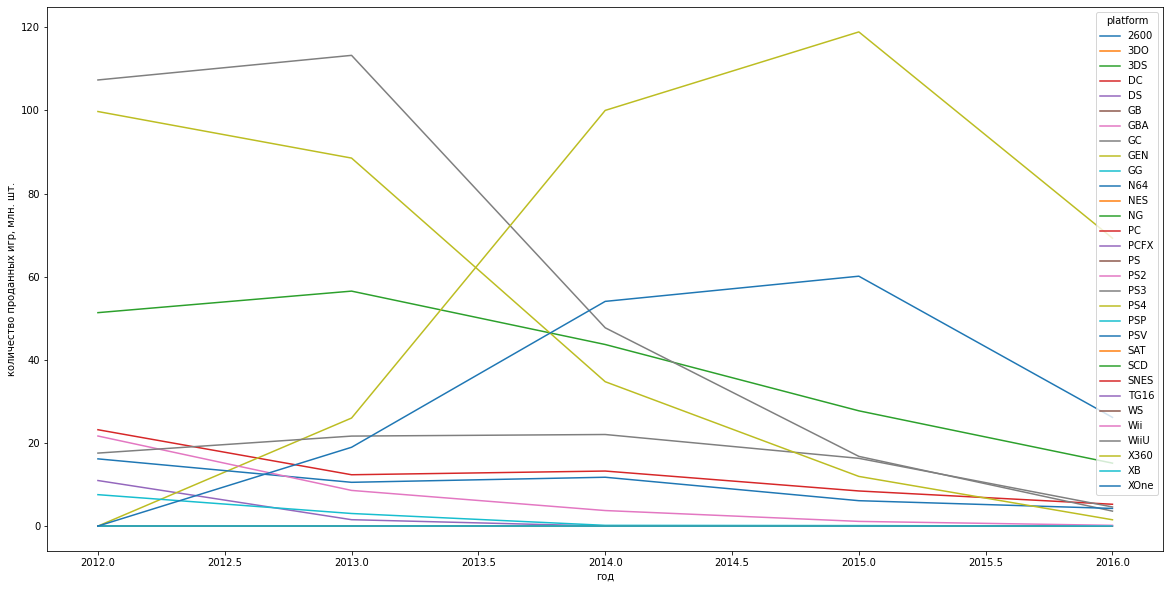

In [40]:
### visualizing data
refined_plot.plot(figsize=(20,10),xlabel='год', ylabel='количество проданных игр, млн. шт.');

После анализа данных на более коротком промежутке можно подтвердить выданные ранее рекомендации:
- ***продажи игр для всех текущих актуальных консолей снижаются, так как мы находимся в конце жизненного цикла консолей.***
- ***необходимо обратить внимание на анонсы новых приставок и сконцентрироваться на продвижении игр для них.***
- ***скорее всего будет анонсирвано продолжение PS и Xbox в 2017 - 2018 годах.***
- ***локомотивы - PS4 и Xbox One, далее идут 3DS и PC + остальные текущие консоли Nintendo.***

### Анализ результатов глобальных продаж игр по платформам:

Для данного анализа построим диаграмму размаха по глобальным продажам игр в разбивке по платформам.

/tmp/ipykernel_113/2119678766.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


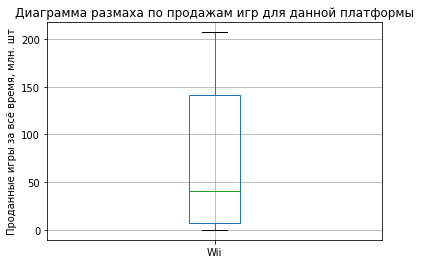

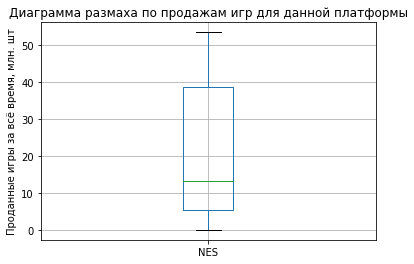

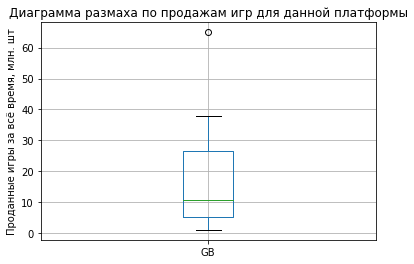

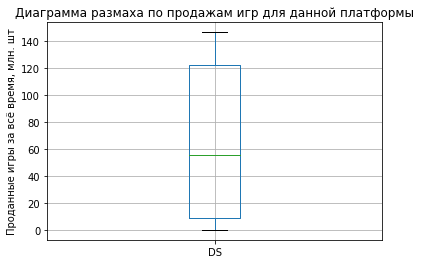

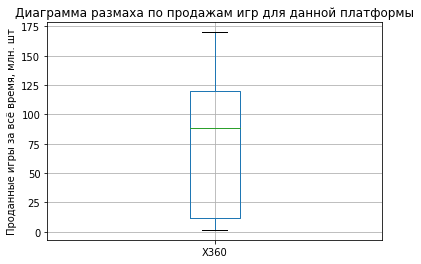

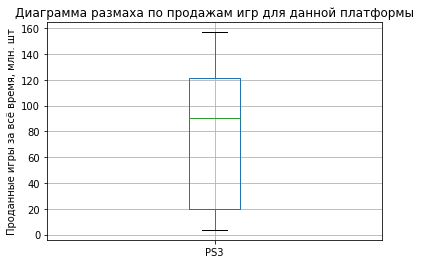

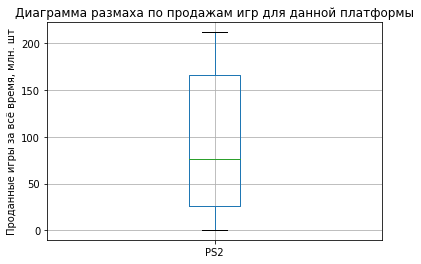

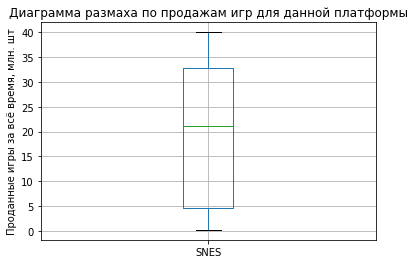

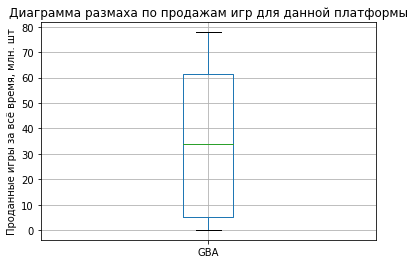

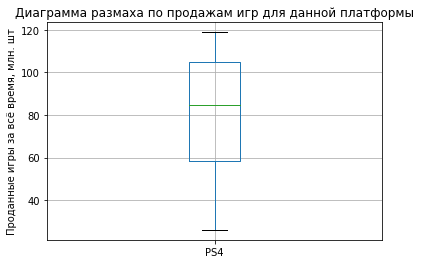

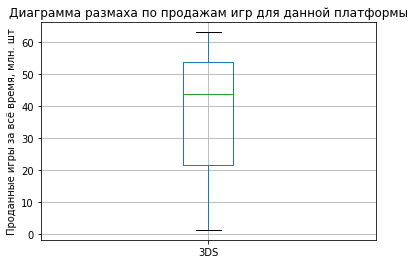

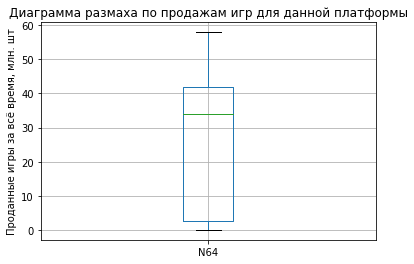

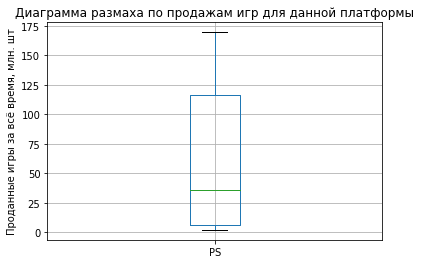

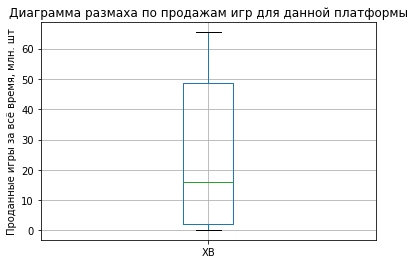

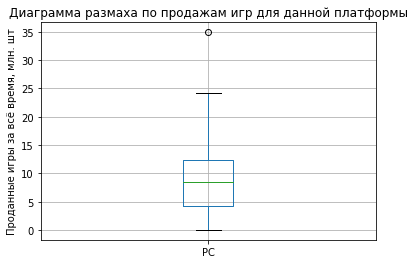

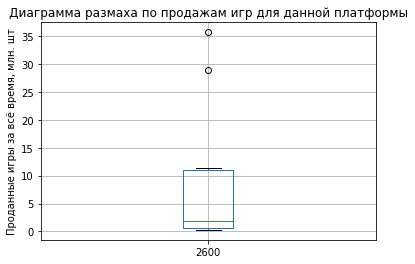

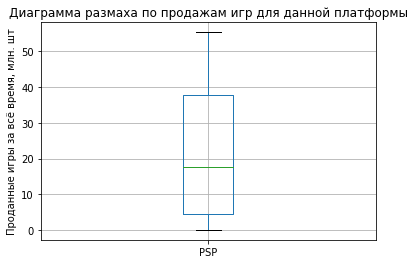

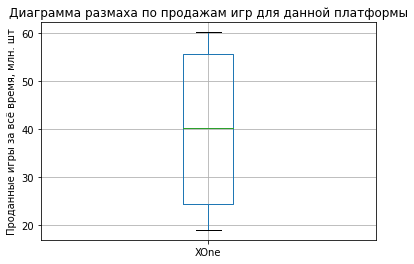

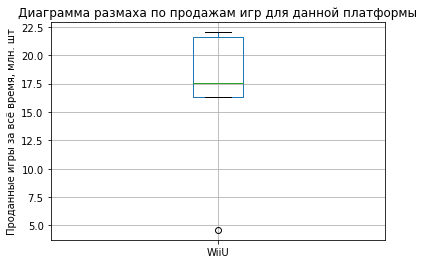

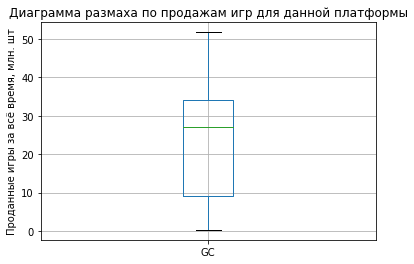

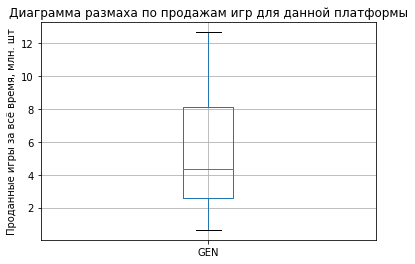

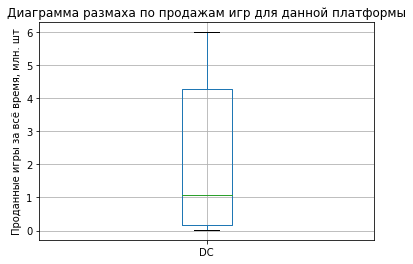

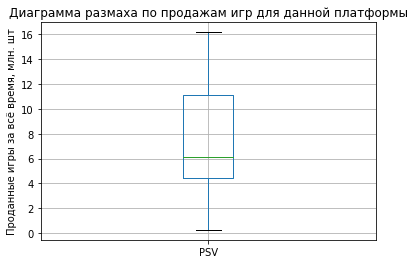

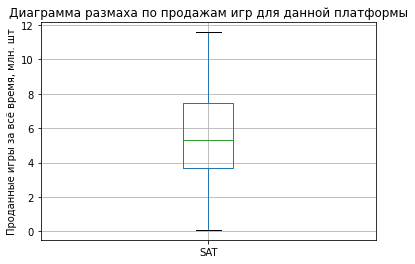

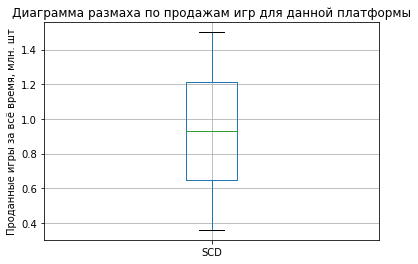

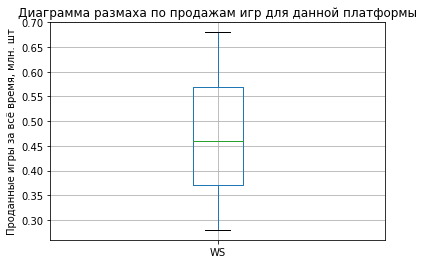

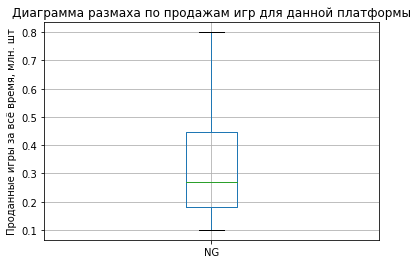

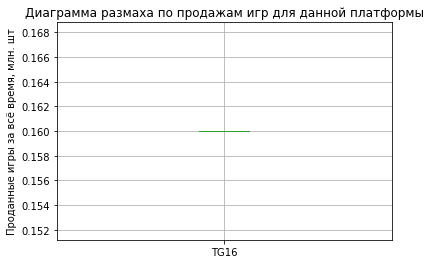

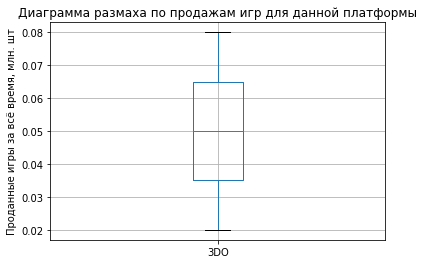

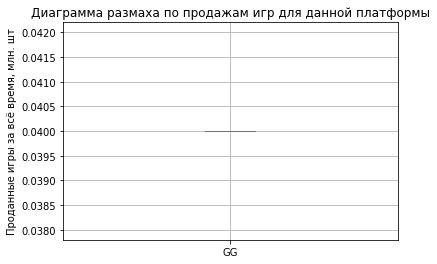

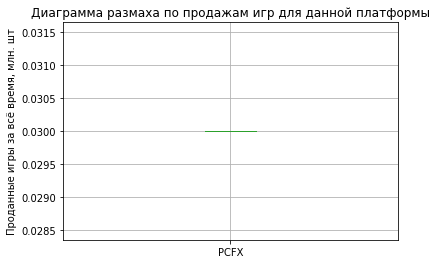

In [41]:
### going through the main dataset, selecting the platform and building the boxplot for this platform
for platform in data['platform'].unique():
    fig, ax = plt.subplots()
    test = data.loc[data['platform'] == platform]
    platforms_year = test.pivot_table(index='year_of_release', values='sales', aggfunc='sum')
    platforms_year.rename(columns = {'sales':platform}, inplace = True)
    ax.set_title('Диаграмма размаха по продажам игр для данной платформы')
    ax.set_ylabel('Проданные игры за всё время, млн. шт')
    ax = platforms_year.boxplot();

Анализ графиков выше позволяет выявить для каждой платформы усреднённое количество игр, которое продавалоь для неё в каждый год её жизненного цикла. Данная информация может быть полезна для планирования продаж после того, как мы определимся с подходящими платформами 2017 года.

Также посмотрим на описание данных:

In [42]:
### using the describe method to get additional incites:
data.pivot_table(index='platform', values='sales', aggfunc='sum').describe()

,sales
count,31.000000
mean,287.293548
std,348.055421
min,0.030000
25%,22.150000
50%,200.030000
75%,303.610000
max,1255.150000


Проанализировав эти данные можно сделать вывод, что в среднем платформа продаёт около 300 млн. копий игр за время своего существования. Однако если платформа очень популярна и для неё выходит множество отличных игр, то количество проданнык копий в мире может исчисляться сотнями миллионов копий.

### Анализ влияния отзывов пользователей и критиков на продажи:

Выберем пару популярных платформ для того чтобы провести анализ корреляции для каждой из них. Допустим это будет PS3 и X360, как противоположенные платформы для которых продали достаточно большое количество игр.

In [43]:
### selecting the data from the dataset based on the condition we set
data_ps3 = data.loc[data['platform'] == 'PS3']

In [44]:
### selecting the data from the dataset based on the condition we set
data_x360 = data.loc[data['platform'] == 'X360']

In [45]:
### creating a sub dataset with only necessary columns to create scatter matrix
data_to_analyse_ps3 = data_ps3[['sales','user_score','critic_score']]

In [46]:
### creating a sub dataset with only necessary columns to create scatter matrix
data_to_analyse_x360 = data_x360[['sales','user_score','critic_score']]

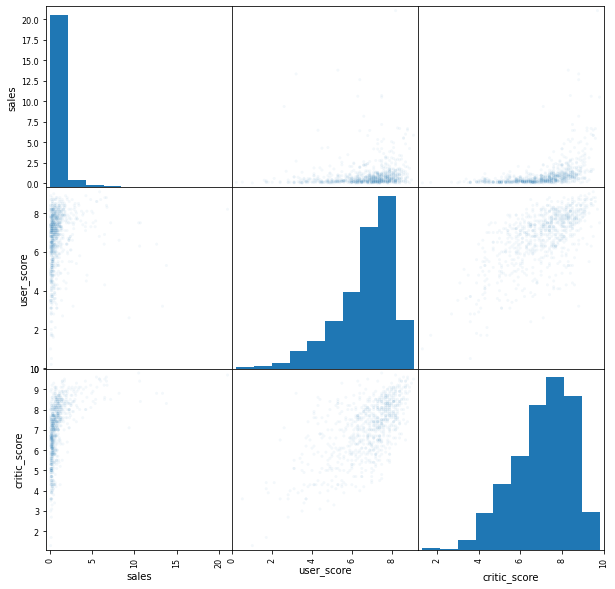

In [47]:
### drowing the scatter matrix
pd.plotting.scatter_matrix(data_to_analyse_ps3, figsize=(10, 10), alpha=0.05);

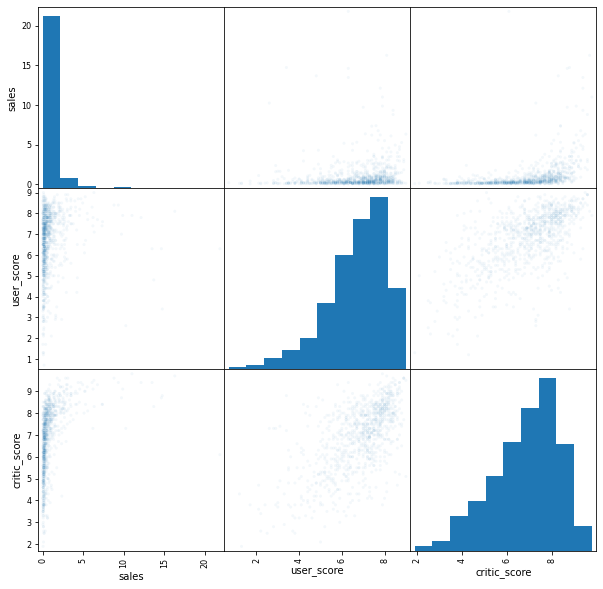

In [48]:
### drowing the scatter matrix
pd.plotting.scatter_matrix(data_to_analyse_x360, figsize=(10, 10), alpha=0.05);

In [49]:
### checking the correlation between data
data_to_analyse_ps3.corr()

,sales,user_score,critic_score
sales,1.000000,0.126919,0.434328
user_score,0.126919,1.000000,0.630381
critic_score,0.434328,0.630381,1.000000


In [50]:
### checking the correlation between data
data_to_analyse_x360.corr()

,sales,user_score,critic_score
sales,1.000000,0.112674,0.393459
user_score,0.112674,1.000000,0.617519
critic_score,0.393459,0.617519,1.000000


Из этого можно сделать вывод, что между пользовательскими оценками и продажами корреляция есть, но она не выражена ярко. На продажи большее влияние оказывают оценки профессиональных критиков. Однако полагаться на выбор продукта для продвижения только на эти данные опрометчиво, так как оценки критиков могут быть необъективны, а оценки пользователей - как раз очень субъективны. Хотя и продвигать игру, которая имеет низкие оценки тоже не стоит. Лучшим вариантом является продукт с оценками польлзователей от 7 до 8 и критиков от 7. Это будет безпроигрышный середнячок вне зависимости от платформы.

### Анализ прибыльности жанров:

Проанализируем общее распределение прибыльности игр по жанрам. Для этого для начала проанализируем данные за всё время:

In [51]:
data.pivot_table(index='genre', values='sales', aggfunc='median').sort_values(by='sales')

,sales
genre,
Adventure,0.07
Strategy,0.11
Puzzle,0.12
Simulation,0.16
Misc,0.17
Role-Playing,0.19
Action,0.20
Racing,0.21
Fighting,0.21


И проанализируем данные только начиная с 2012 года:

In [52]:
refined_data.pivot_table(index='genre', values='sales', aggfunc='median').sort_values(by='sales')

,sales
genre,
Adventure,0.040
Puzzle,0.060
Strategy,0.085
Simulation,0.125
Action,0.130
Role-Playing,0.150
Fighting,0.155
Misc,0.155
Racing,0.170


Можно сказать, что наиболее прибыльными играми с точки зрения стабильно большого числа проданных копий являются игры в шанрах shooter, platform и спортивные. Наименее прибыльниыми - puzzle, strategy и приключенческие. Причем это не зависит от времени. На это точно стоит ориентироваться при продвижении игр в 2017 году.

## Портрет типичного пользователя региона продаж игр.

### Для региона NA (North America):

#### Топ-5 платформ для игроков данного региона.

Для начала проанализируем топ-5 платформ данного региона за период с 2012 года для понимания на чём сосредоточится в 2017 году:

In [53]:
### sorting the refined dataset to have best platforms in sales on the top
refined_data.pivot_table(index='platform', values='na_sales', aggfunc='sum').\
sort_values(by='na_sales', ascending=False).head()

,na_sales
platform,
X360,140.03
PS4,108.74
PS3,103.37
XOne,93.12
3DS,55.28


Результат логичный так как в данном регионе исторически сильны позиции компании Microsoft. В выборе того, какие игры необходимо продвигать необходимо делать уклон в сторону продукции этой компании. На втором месте стоят продукты Sony, так что им тоже следует уделить достаточно внимания. Построим для наглядности также и круговую диаграмму.

In [54]:
### setting the explode parameter for the better visual representation of the pie chart
explode = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, \
           0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

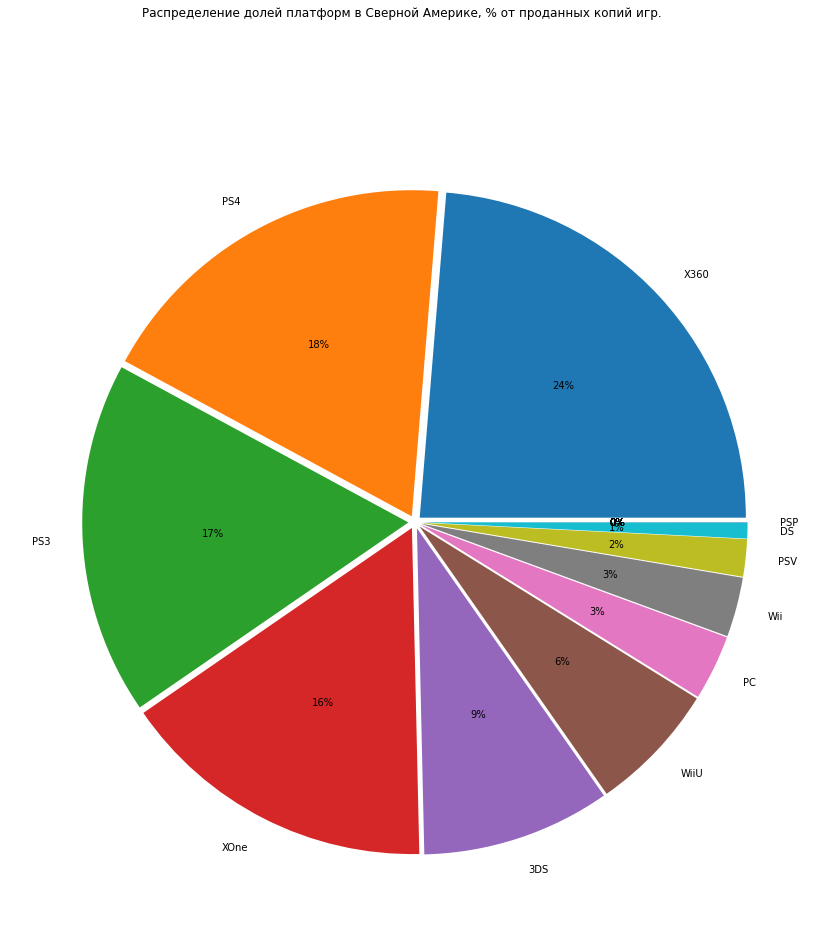

In [55]:
### biulding the pie chart
refined_data.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False) \
.plot.pie(y='na_sales', figsize=(15, 15), subplots=True, autopct='%1.0f%%', explode=explode, \
          title='Распределение долей платформ в Сверной Америке, % от проданных копий игр.', ylabel='', legend=False);

#### Топ-5 жанров игр предпочитаемых игроками данного региона.

С топовыми платформами разобрались, но этого недостаточно. Мало знать на какие платформы обратить внимание, надо еще и понимать на какие жанры. Для этого посмотрим, какие жанры игр исторически предпочитают в данном регионе:

In [56]:
### sorting the refined dataset to have best genres on the top
refined_data.pivot_table(index='genre', values='na_sales', aggfunc='sum').\
sort_values(by='na_sales', ascending=False).head()

,na_sales
genre,
Action,177.81
Shooter,144.77
Sports,81.51
Role-Playing,64.00
Misc,38.19


Как мы видим, приключенческие игры и шутеры составляют большинство от проданных экземпляров. Однако спортивные игры - это то, в чём консоли традиционно сильны и их тоже стоит добавить в ассортимент. Дополнительно визуализируем полученные данные:

In [57]:
### setting the explode parameter for the better visual representation of the pie chart
explode = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

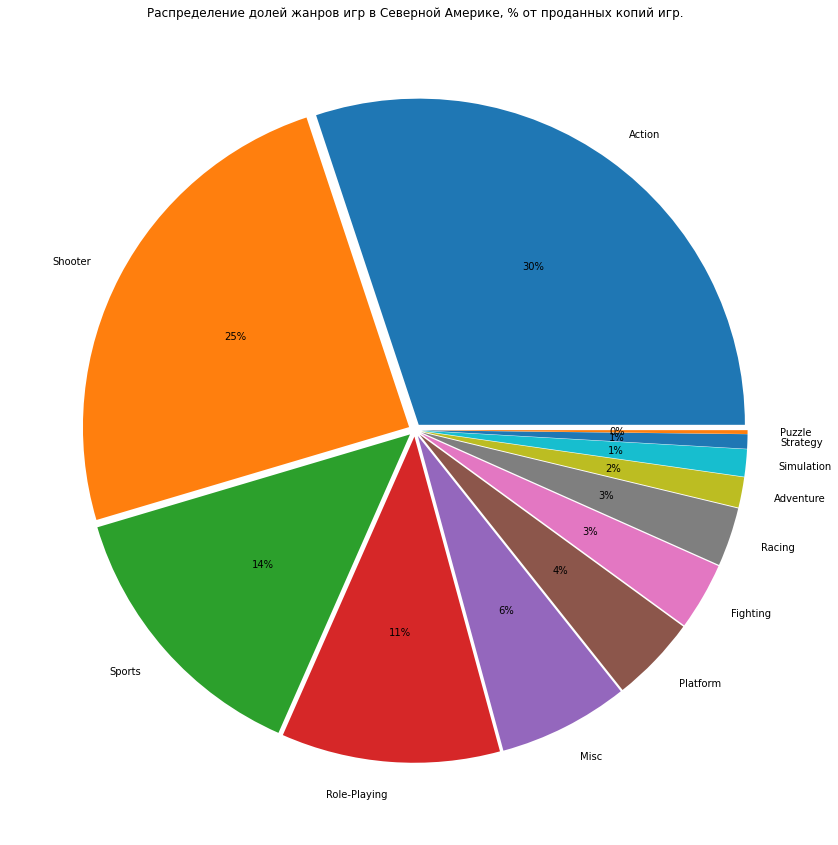

In [58]:
### biulding the pie chart
refined_data.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False) \
.plot.pie(y='na_sales', figsize=(15, 15), autopct='%1.0f%%', explode=explode,\
          title='Распределение долей жанров игр в Северной Америке, % от проданных копий игр.', ylabel='', legend=False);

#### Типичный пользователь региона NA.

Из полученных данных можно судить, что типичный пользователь региона Северная Америка обладает платформой от компании Microsoft (актуального или прошлого поколения) и предпочитает приключенческие игры или игры в жанре шутеров. Вторым по распространённости является клиент с консолями Sony, который предпочитает те же жанры. Дополнительно ассортимент можно расширить за счёт спортивных игр, особенно NFL

### Для региона EU (European Union):

#### Топ-5 платформ для игроков данного региона.

Для начала проанализируем топ-5 платформ данного региона за период с 2012 года для понимания на чём сосредоточится в 2017 году:

In [59]:
### sorting the refined dataset to have best platforms in sales on the top
refined_data.pivot_table(index='platform', values='eu_sales', aggfunc='sum').\
sort_values(by='eu_sales', ascending=False).head()

,eu_sales
platform,
PS4,141.06
PS3,106.79
X360,74.47
XOne,51.55
3DS,42.58


Результат логичный так как в данном регионе уже больше предпочитают продукцию компании Sony, чем Microsoft. В выборе того, какие игры необходимо продвигать необходимо делать уклон в сторону продукции этой компании. На втором месте стоят продукты Microsoft, так что им тоже следует уделить достаточно внимания. Это обусловлено влиянием североамериканского рынка. Построим для наглядности также и круговую диаграмму.

In [60]:
### setting the explode parameter for the better visual representation of the pie chart
explode = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, \
           0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

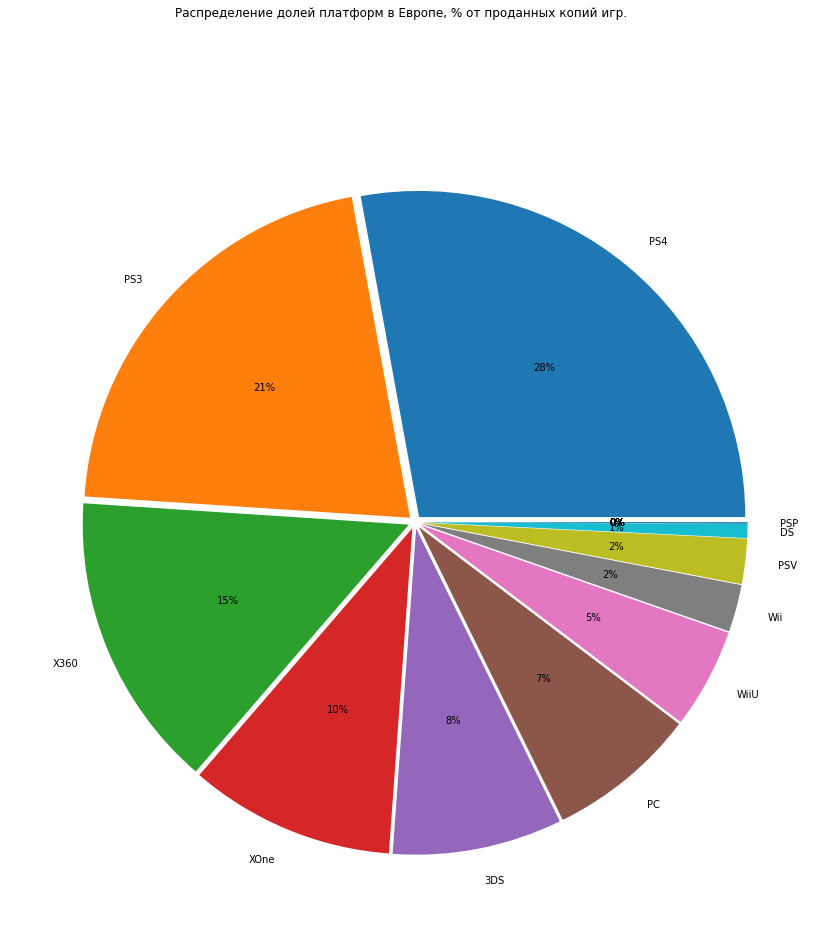

In [61]:
### biulding the pie chart
refined_data.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False) \
.plot.pie(y='eu_sales', figsize=(15, 15), subplots=True, autopct='%1.0f%%', explode=explode, \
          title='Распределение долей платформ в Европе, % от проданных копий игр.', ylabel='', legend=False);

#### Топ-5 жанров игр предпочитаемых игроками данного региона.

С топовыми платформами разобрались, но этого недостаточно. Мало знать на какие платформы обратить внимание, надо еще и понимать на какие жанры. Для этого посмотрим, какие жанры игр исторически предпочитают в данном регионе:

In [62]:
### sorting the refined dataset to have best genres on the top
refined_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum').\
sort_values(by='eu_sales', ascending=False).head()

,eu_sales
genre,
Action,159.08
Shooter,113.46
Sports,68.98
Role-Playing,48.52
Racing,27.25


Как мы видим, в этом регионе также приключенческие игры и шутеры составляют большинство от проданных продуктов. Однако спортивные игры - это то, в чём консоли традиционно сильны и их тоже стоит добавить в ассортимент. Дополнительно визуализируем полученные данные:

In [63]:
### setting the explode parameter for the better visual representation of the pie chart
explode = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

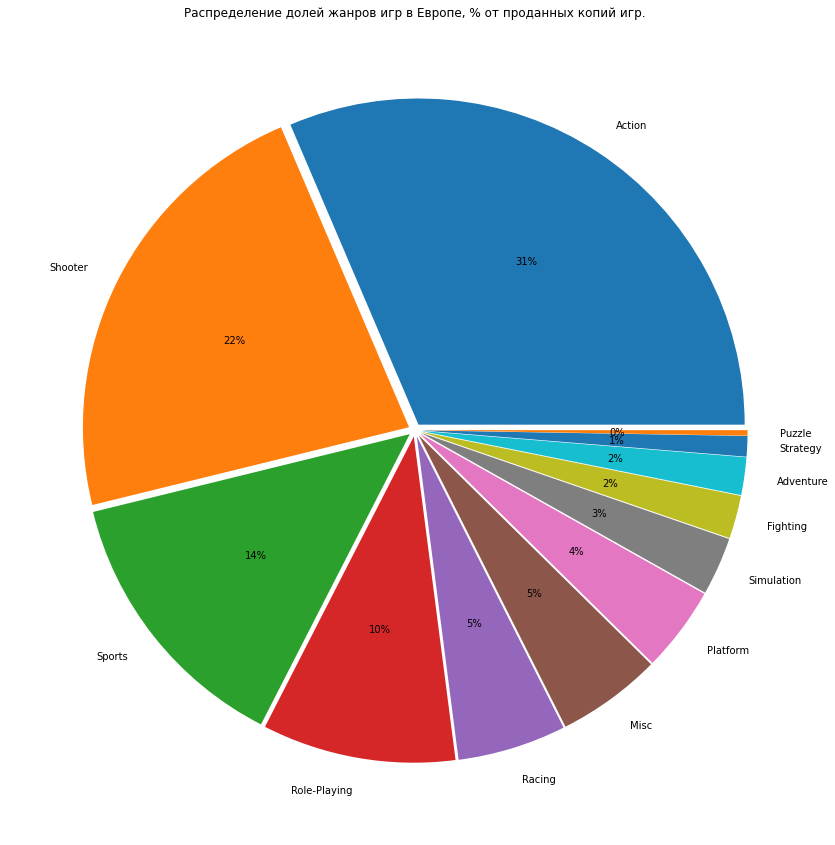

In [64]:
### biulding the pie chart
refined_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False) \
.plot.pie(y='eu_sales', figsize=(15, 15), autopct='%1.0f%%', explode=explode,\
          title='Распределение долей жанров игр в Европе, % от проданных копий игр.', ylabel='', legend=False);

#### Типичный пользователь региона EU.

Из полученных данных можно судить, что типичный пользователь Европейского региона  обладает платформой от компании Sony (актуального или прошлого поколения) и предпочитает приключенческие игры или игры в жанре шутеров. Вторым по распространённости является клиент с консолями Microsoft, который предпочитает те же жанры. Дополнительно ассортимент можно расширить за счёт спортивных игр, особенно FIFA

### Для региона JP (Japan):

#### Топ-5 платформ для игроков данного региона.

Для начала проанализируем топ-5 платформ данного региона за период с 2012 года для понимания на чём сосредоточится в 2017 году:

In [65]:
### sorting the refined dataset to have best platforms in sales on the top
refined_data.pivot_table(index='platform', values='jp_sales', aggfunc='sum').\
sort_values(by='jp_sales', ascending=False).head()

,jp_sales
platform,
3DS,87.68
PS3,35.19
PSV,20.76
PS4,15.95
WiiU,12.98


Результат логичный так как в данном регионе продукцию Microsoft не жалуют. Здесь правят бал Nintendo и Sony. Необходимо учитывать ассортимент именно этих производителей и ориентироваться как на текущие консоли, так и на потенциальные новинки. Дополнительно визуализируем данные.

In [66]:
### setting the explode parameter for the better visual representation of the pie chart
explode = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, \
           0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

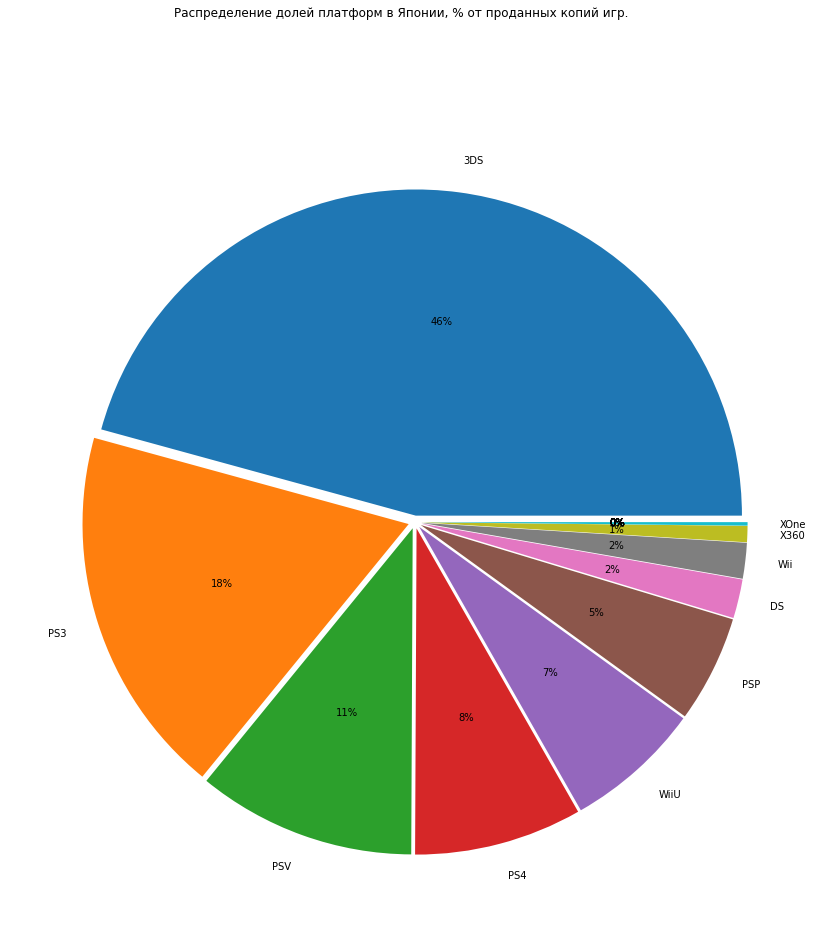

In [67]:
### biulding the pie chart
refined_data.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False) \
.plot.pie(y='jp_sales', figsize=(15, 15), subplots=True, autopct='%1.0f%%', explode=explode, \
          title='Распределение долей платформ в Японии, % от проданных копий игр.', ylabel='', legend=False);

#### Топ-5 жанров игр предпочитаемых игроками данного региона.

С топовыми платформами разобрались, но этого недостаточно. Мало знать на какие платформы обратить внимание, надо еще и понимать на какие жанры. Для этого посмотрим, какие жанры игр исторически предпочитают в данном регионе:

In [68]:
### sorting the refined dataset to have best genres on the top
refined_data.pivot_table(index='genre', values='jp_sales', aggfunc='sum').\
sort_values(by='jp_sales', ascending=False).head()

,jp_sales
genre,
Role-Playing,65.40
Action,52.55
Misc,12.78
Simulation,10.39
Fighting,9.40


Как мы видим, в этом регионе опять есть особенности. Не зря он родоначальник жанра JRPG, который прямо переводится как Japanese Role Playing Game. Пользователи тут предпочитают именно это, а также приключенческие игры и игры, которые не подходят под описание какого-либо жанра. Также можно увидеть, что в список попали файтинги, что опять же характерно для региона.

In [69]:
### setting the explode parameter for the better visual representation of the pie chart
explode = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

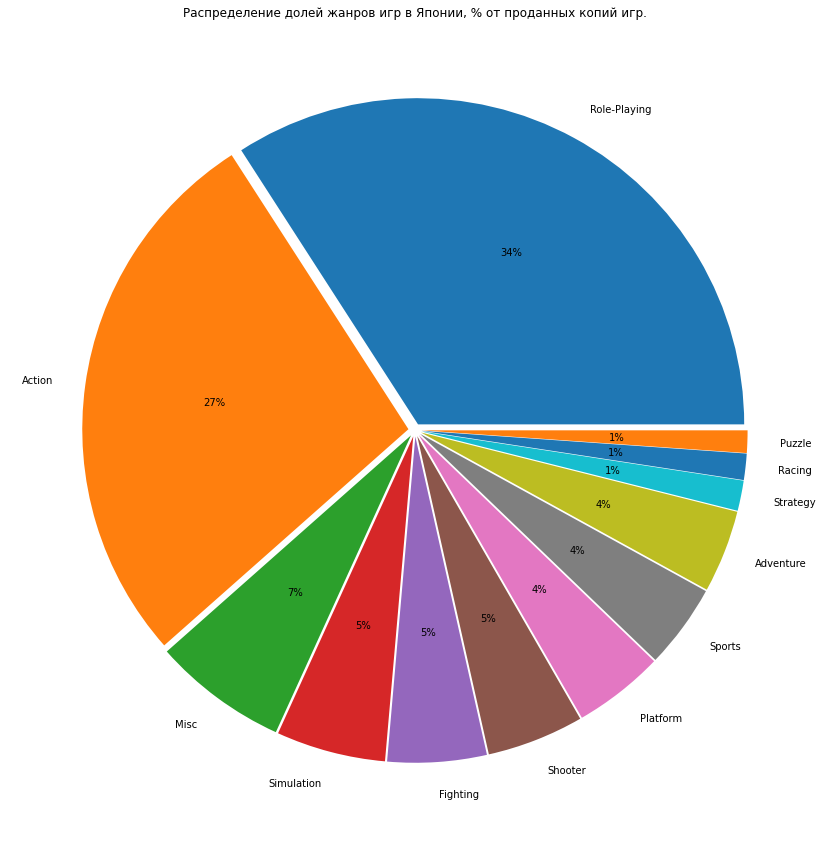

In [70]:
### biulding the pie chart
refined_data.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False) \
.plot.pie(y='jp_sales', figsize=(15, 15), autopct='%1.0f%%', explode=explode,\
          title='Распределение долей жанров игр в Японии, % от проданных копий игр.', ylabel='', legend=False);

#### Типичный пользователь ргиона Japan.

Из полученных данных можно судить, что типичный пользователь данного региона  обладает платформой от компании Nintendo (актуального или прошлого поколения) и предпочитает ролевые или приключенческие игры или игры которые сложно отнести к какому либо жанру. Вторым по распространённости является клиент с консолями Sony, который предпочитает те же жанры. Дополнительно ассортимент можно расширить за счёт игр-симуляторов (возможно - свиданий) и файтингов.

## Анализ влияния рейтинга ESRB на продажи в отдельных регионах

### Влияние рейтинга на регион NA (North America):

Для оценки влияния выберем из датасета данные по продажам игр с определённым рейтингом в данном регионе и построим круговую диаграмму для визуализации данных:

In [71]:
### setting the explode parameter for the better visual representation of the pie chart
explode = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

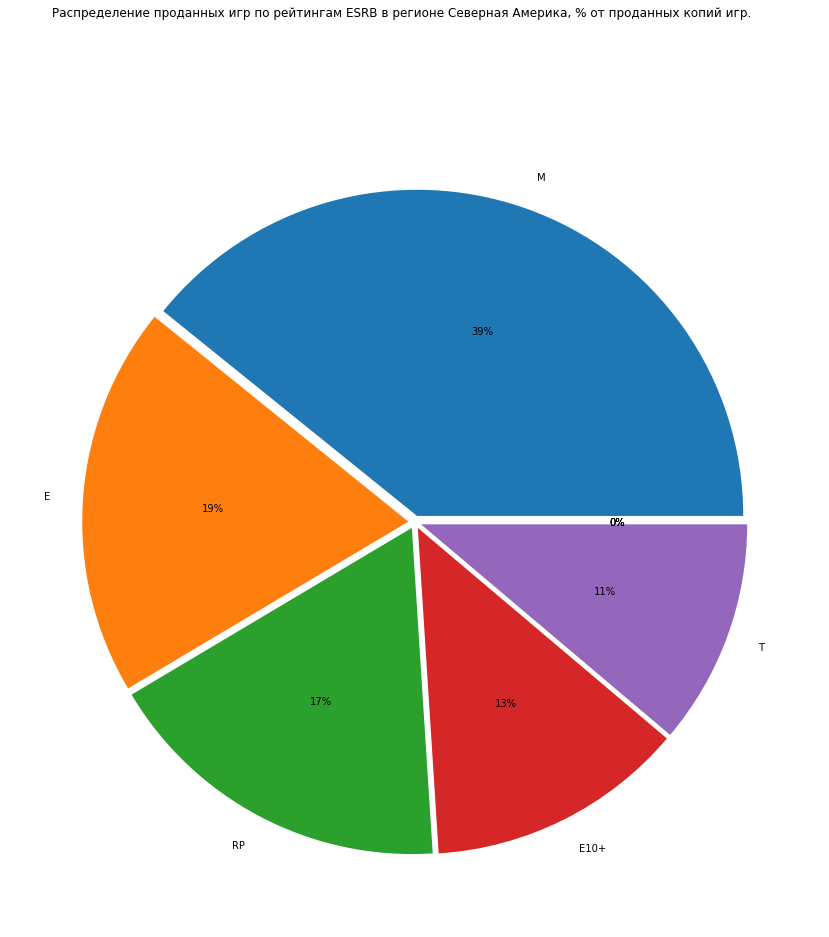

In [72]:
### biulding the pie chart
refined_data.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False) \
.plot.pie(y='na_sales', figsize=(15, 15), subplots=True, autopct='%1.0f%%', explode=explode, \
          title='Распределение проданных игр по рейтингам ESRB в регионе Северная Америка, % от проданных копий игр.',\
          ylabel='', legend=False);

Как мы помним, мы заполнили в начале исследования все пропуски в рейтиге ESRB значениями RP - rating pending, что означает, что игра еще не получила рейтинга и он ожидается, или не присвоен. Так как у нас выборка с 2012 года, то причина не присвоения рейтинга не в том, что на момент выпуска игры его не было, а в том, что он действительно не может быть присвоен по какой-то причине. Однако даже в регионе NA в котором этот рейтинг используется на 100% продажи игр без рейтинга составлают почти 20%, что говорит о том, что на решение о покупке это если и влияет, то не сильно. Скорее всего если целевой аудиторией вашей игры являются именно дети, то рейтинг поможет убедить родителей, что все нормально. Если целевая аудитория от 14 лет и выше, то для них рейтинг не играет существенного значения.

### Влияние рейтинга на регион EU (European Union):

Выберем из датасета данные по продажам игр с определённым рейтингом в данном регионе и построим круговую диаграмму для визуализации данных:

In [73]:
### setting the explode parameter for the better visual representation of the pie chart
explode = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

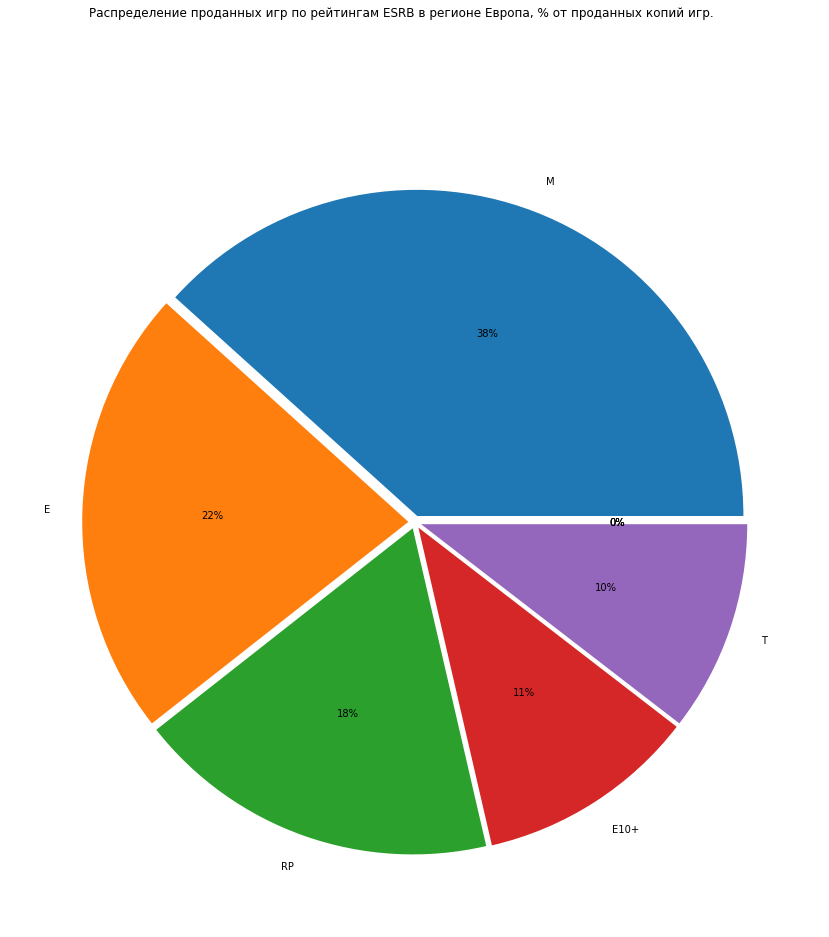

In [74]:
### biulding the pie chart
refined_data.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False) \
.plot.pie(y='eu_sales', figsize=(15, 15), subplots=True, autopct='%1.0f%%', explode=explode, \
          title='Распределение проданных игр по рейтингам ESRB в регионе Европа, % от проданных копий игр.',\
          ylabel='', legend=False);

В Европе Американский рейтинг используется не так часто как в Америке, но с учётом того, что в подавляющем большинстве игры выходят и там и там, то рейтинг у них всё равно есть. Его влияние аналогично тому, как он влияет в Америке или даже меньшее. Опять же зависит от целевой аудитории продукта.

### Влияние рейтинга на регион JP (Japan):

Выберем из датасета данные по продажам игр с определённым рейтингом в данном регионе и построим круговую диаграмму для визуализации данных:

In [75]:
### setting the explode parameter for the better visual representation of the pie chart
explode = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

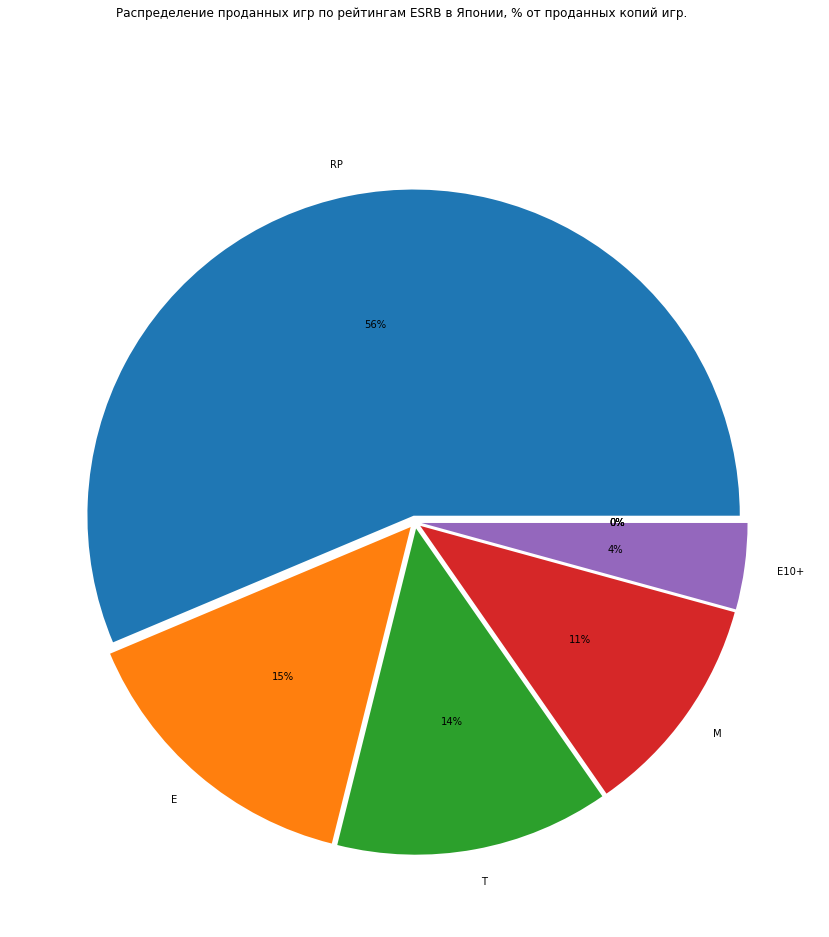

In [76]:
### biulding the pie chart
refined_data.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False) \
.plot.pie(y='jp_sales', figsize=(15, 15), subplots=True, autopct='%1.0f%%', explode=explode, \
          title='Распределение проданных игр по рейтингам ESRB в Японии, % от проданных копий игр.',\
          ylabel='', legend=False);

В Японии по поводу рейтинга можно вообще не переживать. Здесь для принятия решения о покупке игры явно используются какие-то другие параметры. Можно утверждать, что рейтинг ESRB не влияет на продажи на этом рынке.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые:

Сформулируем нулевую гипотезу как то, что средние пользовательские рейтинги платформ Xbox One и PC равны и альтернативную гипотезу как то, что они отличаются. Теперь приступим к проверке нулевой гипотезы:

Для начала сформируем Series из основного датасета в котором будут все пользовательские оценки игр на Xbox One. Мы работаем с генеральноый выборкой, так как количество данных не очень большое.

In [77]:
### preparing necesssary Series with Xbox user scores only from the main dataset
xbox_data_uscore = data.loc[data['platform'] == 'XOne', 'user_score']

Теперь сформируем Series из основного датасета в котором уже будут все пользовательские оценки игр на PC. Мы опять же работаем с генеральноый выборкой, так как количество данных не очень большое.

In [78]:
### preparing necesssary Series with Xbox user scores only from the main dataset
pc_data_uscore = data.loc[data['platform'] == 'PC', 'user_score']

Теперь непосредственно рассчитаем уровень значимости и либо подтвердим, либо опровергнем нулевую гипотезу. Критический уровень статистической значимости оставим 0.05 как стандартный. Выбираем ttest_ind так как проверяем две генеральные совокупности.

In [79]:
### setting alpha for the test
alpha = .05

Параметр equal_var мы принимаем как False, так как у нас не равны выборки.

In [80]:
### performing the comparsion
results = st.ttest_ind(xbox_data_uscore, pc_data_uscore, equal_var=False)

In [81]:
### printing p-value just for reference
print('p-значение:',  results.pvalue)

p-значение: nan


In [82]:
### checking if we can abandon the 0 hypothesis or not
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


К сожалению получается что наша нулевая гипотеза не верна и мы можем утверждать, что средние пользовательские рейтинги платформ Xbox One и PC не одинаковые. Однако можно провести дополнительную проверку просто расчитав среднее:

In [83]:
### calculating mean for user scores on PC
pc_data_uscore.mean()

7.048214

In [84]:
### calculating mean for user scores on Xbox One
xbox_data_uscore.mean()

6.5211115

Как можно убедиться - они действительно не равны.

### Средние пользовательские рейтинги жанров Action и Sports разные:

Сформулируем нулевую гипотезу как то, что средние пользовательские рейтинги жанров Action и Sports равны и альтернативную гипотезу как то, что они отличаются. Теперь приступим к проверке нулевой гипотезы:

Для начала сформируем Series из основного датасета в котором будут все пользовательские оценки игр жанра Action. Мы работаем с генеральноый выборкой, так как количество данных не очень большое.

In [85]:
### preparing necesssary Series with Xbox user scores only from the main dataset
action_uscore = data.loc[data['genre'] == 'Action', 'user_score']

Теперь сформируем Series из основного датасета в котором уже будут все пользовательские оценки игр жанра Sports. Мы опять же работаем с генеральноый выборкой, так как количество данных не очень большое.

In [86]:
### preparing necesssary Series with Xbox user scores only from the main dataset
sport_uscore = data.loc[data['genre'] == 'Sports', 'user_score']

Теперь непосредственно рассчитаем уровень значимости и либо подтвердим, либо опровергнем нулевую гипотезу. Критический уровень статистической значимости оставим 0.05 как стандартный. Выбираем ttest_ind так как проверяем две генеральные совокупности.

In [87]:
### setting alpha for the test
alpha = .05

Параметр equal_var мы принимаем как False, так как у нас не равны выборки.

In [88]:
### performing the comparsion
results = st.ttest_ind(action_uscore, sport_uscore, equal_var=False)

In [89]:
### printing p-value just for reference
print('p-значение:',  results.pvalue)

p-значение: nan


In [90]:
### checking if we can abandon the 0 hypothesis or not
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Получается что наша нулевая гипотеза верна в этот раз и мы можем утверждать, что средние пользовательские рейтинги игр в жанрах Action и Sports - равны. Также можно провести дополнительную проверку просто расчитав среднее:

In [91]:
### calculating mean for user scores on PC
action_uscore.mean()

7.06852

In [92]:
### calculating mean for user scores on Xbox One
sport_uscore.mean()

6.9742885

Как можно убедиться - они действительно почти равны. В рамках принятой нами погрешности.

## ***Выводы:***

Основная задача анализа выглядела как: На какой продукт сделать ставку в 2017 году для получения максимальной прибыли? 
Вот, к каким выводам мы пришли после анализа предоставленных данных:
- Общие выводы:
    - Судя по нашим данным текущее поколение консолей основных производителей находится в конце жизненного цикла и не стоит для них в 2017 ожидать прорывных продуктов. Все внимание приковано к новым поколениям, которые как раз могут выйти в 2017 или 2018 году и следует внимательно отслеживать как анонсы платформ, так и эксклюзивов для них. Отдельно стоит упомянуть рынок игр для PC - он более стабилен, несмотря на то, что также на спаде и не очень большой по объёму.
    - ***Лучше сосредоточится на продвижении игр с рейтингом критиков и пользователей около 7-8 баллов, так как такие игры имеют больший шанс хорошо продаться.***
- Для региона NA - в целом сосредоточится на продвижении продуктов Microsoft в жанре Action.
    - ***Предпочтение следует отдавать играм жанров Action, Shooter или Sports***
    - ***Около 40% ассортимента должно быть для актуальных консолей Microsoft***
    - Около 35% ассортимента должно быть для актуальных консолей Sony
    - Около 25% ассортимента должно быть для актуальных консолей Nintendo или PC
- Для региона EU - в целом сосредоточится на продвижении продуктов Sony в жанре Action.
    - ***Предпочтение следует отдавать играм жанров Action, Shooter или Sports***
    - ***Около 50% ассортимента должно быть для актуальных консолей Sony***
    - Около 25% ассортимента должно быть для актуальных консолей Microsoft
    - Около 25% ассортимента должно быть для актуальных консолей Nintendo или PC
- Для региона JP - в целом сосредоточится на продвижении продуктов Nintendo в жанре role playing game.:
    - ***Предпочтение следует отдавать играм жанров RPG или Action***
    - ***Около 60% ассортимента должно быть для актуальных консолей Nintendo***
    - Около 40% ассортимента должно быть для актуальных консолей Sony

